### Scope: The players roughly approximate all players that would be owned in a 12-team league, hold for some very-deep sleepers. The counts are shown below:
`[('QB', 50), ('RB', 100), ('WR', 150), ('TE', 30), ('D/ST', 32), ('K', 40)]`<br><br>
More details can be found in the `download_projection_data` notebook. 

# Part 1: Mean Absolute Deviation (MAD)
## a) All players

In [39]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open(r'data/projections_2021_thru_wk_15_ppr.json', 'r') as f:
    jsons = json.load(f)

In [40]:
recs = pd.DataFrame(jsons)
recs.shape

(6030, 5)

In [41]:
recs.head()

,name,points,projected,position,week
0,Josh Allen,17.20,21.60,QB,1
1,Patrick Mahomes,33.28,22.19,QB,1
2,Kyler Murray,33.56,22.17,QB,1
3,Lamar Jackson,18.00,22.27,QB,1
4,Tom Brady,27.16,21.54,QB,1


In [42]:
recs = recs.loc[recs['projected'] >= 1.0].copy()
recs.shape

(4246, 5)

### Are these projections accurate on average?

In [43]:
recs['prmp'] = recs['projected'] - recs['points']
recs['mae'] = recs['prmp'].abs()

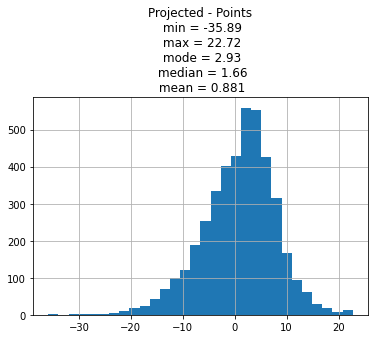

In [44]:
recs.prmp.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(np.round(recs.prmp.min(), 3), np.round(recs.prmp.max(), 3), np.round(recs.prmp.mode()[0], 3), np.round(recs.prmp.median(), 3), np.round(recs.prmp.mean(), 3)))
plt.show()

Interesting to note ESPN overprojects by 0.88 on average vs 2020 of -0.07

### Are these projections precise on average using bootstrap as a test for statistical significance
inspired by https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

In [45]:
rng = np.random.default_rng(seed=69)
N, n = 10000, len(recs)  # draw len(recs) independent samples with replacement 2000 times
X = recs.prmp.values
bs = rng.choice(X, replace=True, size = (N, n))
means_bs = bs.mean(axis=1)
meds_bs = np.median(bs, axis=1)

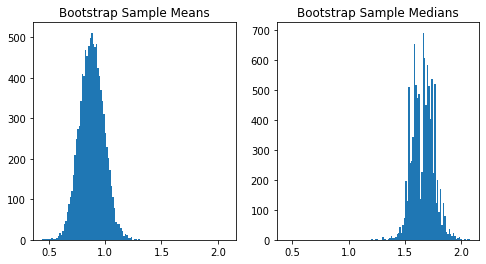

In [46]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
axs[0].hist(means_bs, bins='auto')
axs[0].set(title='Bootstrap Sample Means')
axs[1].hist(meds_bs, bins='auto')
axs[1].set(title='Bootstrap Sample Medians')
plt.show()

In [47]:
std_mean_bs = means_bs.std(ddof=1)
print('\nStandard error of mean:', std_mean_bs)
print('95% CI of mean samples: ', np.quantile(means_bs, [0.025, 0.975]))

std_med_bs = meds_bs.std(ddof=1)
print('\nStandard error of median:', std_med_bs)
print('95% CI of median samples: ', np.quantile(meds_bs, [0.025, 0.975]))


Standard error of mean: 0.10713236214362416
95% CI of mean samples:  [0.67452514 1.08777449]

Standard error of median: 0.09598366759738115
95% CI of median samples:  [1.5      1.845125]


Observations
- According to our bootstrap analysis, the sampling distribution and 95% CI of the median & mean shown above does not include zero. Therefore we reject the null hypothesis that projected - points are equal zero.

### Using projections for start/sit decisions

In [48]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [49]:
check = [-20, -10, -5, -3, -2, -1, 0, 1, 2, 3, 5, 10, 20]
density = []

def proj(i):
    return 'underprojects' if i < 0 else 'overprojects'

for i in range(1, len(check)):
    val = (find_nearest_argmin(recs.prmp.sort_values().values, check[i]) \
     - find_nearest_argmin(recs.prmp.sort_values().values, check[i-1]))/len(recs.prmp)
    density.append(val)
    print('ESPN {} between {} and {} {}% of the time'.format(proj(check[i-1]), check[i-1], check[i], np.round(val*100, 2)))
print('total distribution covered: {}%'.format(np.round(sum(density), 4)*100))
left, right = -3, 3
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))
print('\nOverall, ESPN underprojects {}% of the time'.format(np.round(sum(density[check.index(-20):check.index(0)])*100,2)))
print('Overall, ESPN overprojects {}% of the time'.format(np.round(sum(density[check.index(0):check.index(20)])*100,2)))

ESPN underprojects between -20 and -10 6.57% of the time
ESPN underprojects between -10 and -5 11.26% of the time
ESPN underprojects between -5 and -3 7.7% of the time
ESPN underprojects between -3 and -2 4.57% of the time
ESPN underprojects between -2 and -1 4.88% of the time
ESPN underprojects between -1 and 0 5.23% of the time
ESPN overprojects between 0 and 1 4.95% of the time
ESPN overprojects between 1 and 2 6.74% of the time
ESPN overprojects between 2 and 3 6.71% of the time
ESPN overprojects between 3 and 5 13.14% of the time
ESPN overprojects between 5 and 10 20.58% of the time
ESPN overprojects between 10 and 20 6.76% of the time
total distribution covered: 99.08%

mass between -3 and 3 33.07%

Overall, ESPN underprojects 40.2% of the time
Overall, ESPN overprojects 58.88% of the time


Observations
- As is consistent with the 2014 season analysis, ESPN overprojects, on average: https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/
- Second year in a row this trend is observed by me
- This year confirmed that this information is provided by the Watson models

## b) Starter Worthy
We will used point projections as a reasonable proxy for whether a player can expert to be started, broken down by position using my own subjective judgement. We will choose to exclude `D/ST` and `K` since the goodness of fit analysis seems to suggest projection data materially imprecise. 

In [50]:
recs = pd.DataFrame(jsons)
recs.shape

(6030, 5)

In [51]:
idxs = []
for k, v in [('QB', 10), ('RB', 5), ('WR', 8), ('TE', 5)]:
    hold = recs.loc[(recs['position'] == k) & (recs['projected'] >= v)]
    print('Approximate number of players per week for {}: {}, min: {}'.format(k, int(hold.groupby(by='week')['projected'].count().mean()), hold.groupby(by='week')['projected'].count().min()))
    idxs = idxs + list(hold.index.values)
len(idxs)

Approximate number of players per week for QB: 29, min: 25
Approximate number of players per week for RB: 52, min: 46
Approximate number of players per week for WR: 63, min: 54
Approximate number of players per week for TE: 22, min: 19


2522

These look solid.

In [52]:
recs = recs.iloc[idxs]
recs.shape

(2522, 5)

In [53]:
recs['prmp'] = recs['projected'] - recs['points']
recs['mae'] = recs['prmp'].abs()

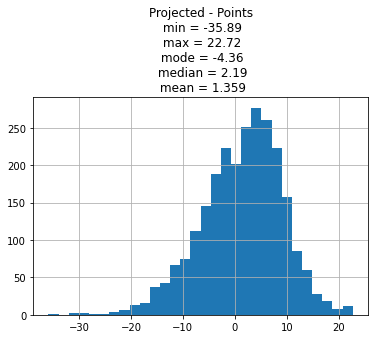

In [54]:
recs.prmp.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(np.round(recs.prmp.min(), 3), np.round(recs.prmp.max(), 3), np.round(recs.prmp.mode()[0], 3), np.round(recs.prmp.median(), 3), np.round(recs.prmp.mean(), 3)))
plt.show()

Even more pronounced overprojection (bias) of 1.36 vs 0.13 last year. Perhaps due to Watson full implementation?

### Are these projections precise on average using bootstrap as a test for statistical significance
inspired by https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

In [55]:
rng = np.random.default_rng(seed=69)
N, n = 10000, len(recs)  # draw len(recs) independent samples with replacement 2000 times
X = recs.prmp.values
bs = rng.choice(X, replace=True, size = (N, n))
means_bs = bs.mean(axis=1)
meds_bs = np.median(bs, axis=1)

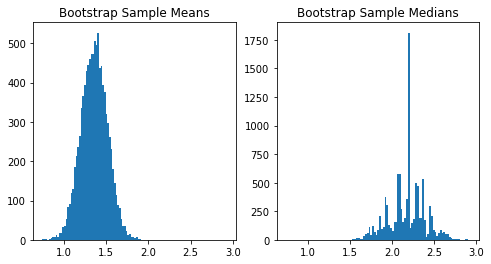

In [56]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
axs[0].hist(means_bs, bins='auto')
axs[0].set(title='Bootstrap Sample Means')
axs[1].hist(meds_bs, bins='auto')
axs[1].set(title='Bootstrap Sample Medians')
plt.show()

In [57]:
std_mean_bs = means_bs.std(ddof=1)
print('\nStandard error of mean:', std_mean_bs)
print('95% CI of mean samples: ', np.quantile(means_bs, [0.025, 0.975]))

std_med_bs = meds_bs.std(ddof=1)
print('\nStandard error of median:', std_med_bs)
print('95% CI of median samples: ', np.quantile(meds_bs, [0.025, 0.975]))


Standard error of mean: 0.15639104559408307
95% CI of mean samples:  [1.05584397 1.66040474]

Standard error of median: 0.21008378990209575
95% CI of median samples:  [1.735 2.61 ]


Observations<br>
Same as above.

### Using projections for start/sit decisions

In [58]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [59]:
check = [-20, -10, -5, -3, -2, -1, 0, 1, 2, 3, 5, 10, 20]
density = []

def proj(i):
    return 'underprojects' if i < 0 else 'overprojects'

for i in range(1, len(check)):
    val = (find_nearest_argmin(recs.prmp.sort_values().values, check[i]) \
     - find_nearest_argmin(recs.prmp.sort_values().values, check[i-1]))/len(recs.prmp)
    density.append(val)
    print('ESPN {} between {} and {} {}% of the time'.format(proj(check[i-1]), check[i-1], check[i], np.round(val*100, 2)))
print('total distribution covered: {}%'.format(np.round(sum(density), 4)*100))
left, right = -3, 3
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))
print('\nOverall, ESPN underprojects {}% of the time'.format(np.round(sum(density[check.index(-20):check.index(0)])*100,2)))
print('Overall, ESPN overprojects {}% of the time'.format(np.round(sum(density[check.index(0):check.index(20)])*100,2)))

ESPN underprojects between -20 and -10 7.77% of the time
ESPN underprojects between -10 and -5 11.02% of the time
ESPN underprojects between -5 and -3 7.22% of the time
ESPN underprojects between -3 and -2 4.72% of the time
ESPN underprojects between -2 and -1 4.28% of the time
ESPN underprojects between -1 and 0 4.88% of the time
ESPN overprojects between 0 and 1 3.73% of the time
ESPN overprojects between 1 and 2 4.68% of the time
ESPN overprojects between 2 and 3 4.8% of the time
ESPN overprojects between 3 and 5 10.94% of the time
ESPN overprojects between 5 and 10 23.75% of the time
ESPN overprojects between 10 and 20 10.79% of the time
total distribution covered: 98.57000000000001%

mass between -3 and 3 27.08%

Overall, ESPN underprojects 39.89% of the time
Overall, ESPN overprojects 58.68% of the time


## c) Starter Worthy, normalized
Let's normalize the projections since we are more concerned with large misses than small. 

In [60]:
recs = pd.DataFrame(jsons)
recs.shape

(6030, 5)

In [61]:
idxs = []
for k, v in [('QB', 10), ('RB', 5), ('WR', 8), ('TE', 5)]:
    hold = recs.loc[(recs['position'] == k) & (recs['projected'] >= v)]
    print('Approximate number of players per week for {}: {}, min: {}'.format(k, int(hold.groupby(by='week')['projected'].count().mean()), hold.groupby(by='week')['projected'].count().min()))
    idxs = idxs + list(hold.index.values)
len(idxs)

Approximate number of players per week for QB: 29, min: 25
Approximate number of players per week for RB: 52, min: 46
Approximate number of players per week for WR: 63, min: 54
Approximate number of players per week for TE: 22, min: 19


2522

These look solid.

In [62]:
recs = recs.iloc[idxs]
recs.shape

(2522, 5)

In [63]:
recs['prmp_norm'] = (recs['projected'] - recs['points'])/recs['projected']

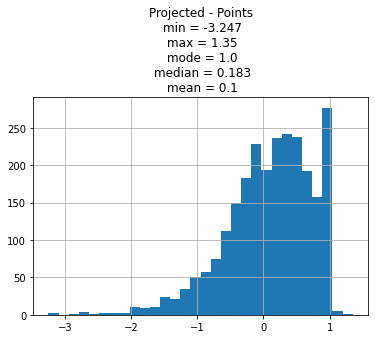

In [64]:
recs.prmp_norm.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(np.round(recs.prmp_norm.min(), 3), np.round(recs.prmp_norm.max(), 3), np.round(recs.prmp_norm.mode()[0], 3), np.round(recs.prmp_norm.median(), 3), np.round(recs.prmp_norm.mean(), 3)))
plt.show()

ESPN is overprojecting by about 10% on average with a median of 18% for these starter worthy forecasts. Fascinating bias by ESPN/Watson.

Note when we say projections, these are the ones provided by ESPN. Previously, they were based on Excel models. We will have to analyze the Watson distributions to determine whether these are the median values from the distribution.

### Are these projections precise on average using bootstrap as a test for statistical significance
inspired by https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

In [65]:
rng = np.random.default_rng(seed=69)
N, n = 10000, len(recs)  # draw len(recs) independent samples with replacement 2000 times
X = recs.prmp_norm.values
bs = rng.choice(X, replace=True, size = (N, n))
means_bs = bs.mean(axis=1)
meds_bs = np.median(bs, axis=1)

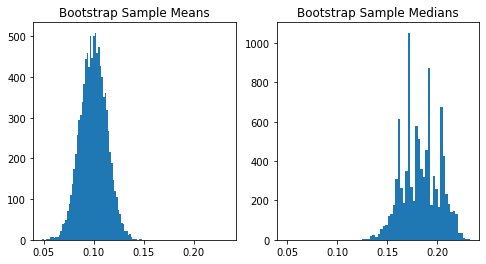

In [66]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
axs[0].hist(means_bs, bins='auto')
axs[0].set(title='Bootstrap Sample Means')
axs[1].hist(meds_bs, bins='auto')
axs[1].set(title='Bootstrap Sample Medians')
plt.show()

In [67]:
std_mean_bs = means_bs.std(ddof=1)
print('\nStandard error of mean:', std_mean_bs)
print('95% CI of mean samples: ', np.quantile(means_bs, [0.025, 0.975]))

std_med_bs = meds_bs.std(ddof=1)
print('\nStandard error of median:', std_med_bs)
print('95% CI of median samples: ', np.quantile(meds_bs, [0.025, 0.975]))


Standard error of mean: 0.01308991420360737
95% CI of mean samples:  [0.07440877 0.12511999]

Standard error of median: 0.01846947989091561
95% CI of median samples:  [0.14888002 0.21715353]


Observations (same as b) as expected)
- According to our bootstrap analysis, the sampling distribution and 95% CI of the median shown above does not include zero. Therefore we reject the null hypothesis that the normalized projected - points data is different from zero.

### Using projections for start/sit decisions

In [68]:
check = [-5, -1, -.5, -.25, -.1, -.05, -.01, 0, .01, .05, .1, .25, .5, 1, 5]
density = []

def proj(i):
    return 'underprojects' if i < 0 else 'overprojects'

for i in range(1, len(check)):
    val = (find_nearest_argmin(recs.prmp_norm.sort_values().values, check[i]) \
     - find_nearest_argmin(recs.prmp_norm.sort_values().values, check[i-1]))/len(recs.prmp_norm)
    density.append(val)
    print('ESPN {} between {} and {} {}% of the time'.format(proj(check[i-1]), check[i-1], check[i], np.round(val*100, 2)))
print('total distribution covered: {}%'.format(np.round(sum(density), 4)*100))
left, right = -.1, .1
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))
left, right = -.25, .25
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))

ESPN underprojects between -5 and -1 6.15% of the time
ESPN underprojects between -1 and -0.5 10.03% of the time
ESPN underprojects between -0.5 and -0.25 9.99% of the time
ESPN underprojects between -0.25 and -0.1 8.72% of the time
ESPN underprojects between -0.1 and -0.05 2.82% of the time
ESPN underprojects between -0.05 and -0.01 2.3% of the time
ESPN underprojects between -0.01 and 0 0.71% of the time
ESPN overprojects between 0 and 0.01 0.67% of the time
ESPN overprojects between 0.01 and 0.05 1.67% of the time
ESPN overprojects between 0.05 and 0.1 2.14% of the time
ESPN overprojects between 0.1 and 0.25 9.12% of the time
ESPN overprojects between 0.25 and 0.5 15.98% of the time
ESPN overprojects between 0.5 and 1 20.18% of the time
ESPN overprojects between 1 and 5 9.48% of the time
total distribution covered: 99.96000000000001%

mass between -0.1 and 0.1 10.31%

mass between -0.25 and 0.25 28.15%


They're within 10% accurate 11% of the time and within 25% almost a third of the time. 

# Part 2: Goodness of fit analysis & Regression
Inspired by Steven Morse's Blog Post: Checking ESPN Fantasy Football Projections with Python<br>
https://stmorse.github.io/journal/espn-fantasy-projections.html

In [69]:
from sklearn.linear_model import LinearRegression

$R^2$ from linear regression is the same as when it is derived from correlation

In [70]:
recs = pd.DataFrame(jsons)
recs = recs.loc[recs['projected'] >= 1.0].copy()

data = recs.loc[recs['position'] == 'K']
pts = data[['projected', 'points']].values
X = pts[:, 0].reshape(-1, 1)
y = pts[:, 1]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10) == np.round(reg.score(X, y), 10), \
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10)

(True, 0.0133284306)

Projections are a worse fit than last year (score was 0.0186)

$\sqrt{R^2} = r_{xy} = \frac{Cov(X, Y)}{s_X s_y}$

In [71]:
# correlation is covariance normalized by the product of std_x and std_y
np.round((data[['projected', 'points']].cov().iloc[0, 1] / (data['projected'].std() * data['points'].std())), 10) \
    == np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)\
    , np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)

(True, 0.1154488223)

Correlation of 0.115 this year vs 0.136.

In [72]:
class Stats:
    """Used to check out work.
    Ref https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/"""
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()

$\hat{\beta}_1 = r \frac{s_Y}{s_X}$<br>
$R^2 = \frac{TSS - RSS}{TSS} =$ how much variation in y can be explained by variation in x <br>
$RSS = \sum_{i=1}^n e_i^2$ where $e_i = y_i - \hat{y_i}$ <br>
$TSS = \sigma^2 n$

In [73]:
print('R^2 via correlation', data[['projected', 'points']].corr().iloc[0, 1]**2)

R^2 via correlation 0.013328430559879138


In [74]:
rss = ((pts[:, 1] - pts[:, 0])**2).sum()
print('RSS for y hat = x:', rss)
print('RSS for y hat', Stats(X, y, reg).sse())

RSS for y hat = x: 10246.6603
RSS for y hat 10076.856324797413


In [75]:
print('R^2 for y hat = x', 1 - rss/(pts[:, 1].var()*len(pts)))
print('R^2 for y hat', Stats(X, y, reg).r_squared())

R^2 for y hat = x -0.003297861342091979
R^2 for y hat 0.013328430559879423


According to KhanAcademy, "$R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use least-squares regression on the x variable." Per the above, the $R^2$ depends on your definition of $\hat{y}$. Traditionally, $\hat{y_i}$ corresponds to the predicted value using the least squares estimate or the line that maximizes $R^2$. This is also the $\hat{y_i}$ you get when calculating $R^2$ with correlation. <br>

However for our problem, we are keen to know how well the data fits the true line, x=y since our x is trying to directly fit y. While this is not the least-squares regression, our non-OLS $R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use the projections."

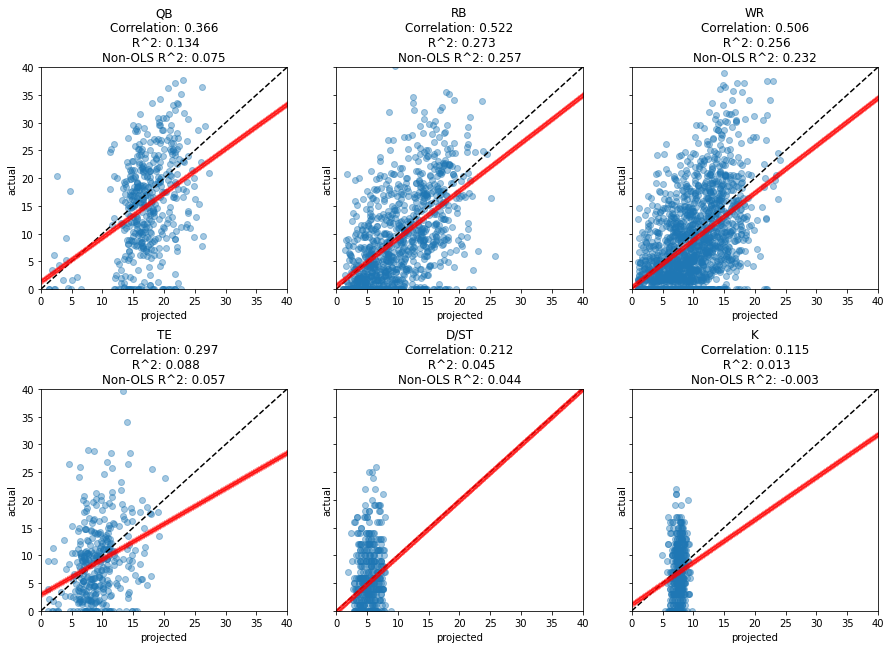

In [76]:
rows = 3
fig, axs = plt.subplots(2, rows, sharey=True, figsize=(15,10))
for i, p in enumerate(['QB', 'RB', 'WR', 'TE', 'D/ST', 'K']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    r = data[['points', 'projected']].corr().iloc[0, 1]
    r2 = r ** 2
    y_hat_x = pts[:, 0]
    x_r2 = 1- ((pts[:, 1] - y_hat_x)**2).sum() / (pts[:, 1].var()*len(pts))
    X = pts[:, 0].reshape(-1, 1)
    y = pts[:, 1]
    reg = LinearRegression().fit(X, y)
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), np.linspace(0, 50, 1000), 'k--')
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), reg.predict(np.linspace(0, 50, 1000).reshape(-1, 1)), 'r+', alpha=0.25)
    axs[i//rows][i%rows].scatter(data['projected'], data['points'], alpha=0.4)
    axs[i//rows][i%rows].set(xlim=[0, 40], ylim=[0, 40], xlabel='projected', ylabel='actual', 
                             title='{}\nCorrelation: {}\n R^2: {}\nNon-OLS R^2: {}'.format(p, np.round(r, 3), np.round(r2, 3), np.round(x_r2, 3))
                            )
plt.subplots_adjust(hspace=0.45)
plt.show()

### Takeaways 2021
- All positions are worse than last year
  - WR is only position (except kickers which was already useless) with R^2 reduction less than 5
- This probably accounts for some season over season variance
- Covid shouldn't be taken into account here since players not playing due to Covid are given a projection
  - Perhaps there is a small effect with other players being boosted up due to last minute players getting covid, but the overall rate of this occurring seems marginal; also you'd expect evidence to understate projections if that were the case gather than over
  - If a player was out due to covid, they received a projection of 0 and would have been excluded from this analysis

### Takeaways 2020 (see GitHub for source):
- RB projections are the strongest with around 33% of the variation in the actual value explained by the projection
  - This is likely explained by the fact that their are fewer RBs competing than WRs and in PPR formats, the number of catches is significantly lower variance than for WRs
- QB R^2 is below that of WR and RB
- Prediction accuracy is mostly useless aside from being able to know that a player projected to score 20 will do better tha one projected to score 10
- Kicker projections are practially uncorrelated and by that metric, meaningless
- TE accuracy has the lowest $R^2$ of all the flex positions
  - As shown below in the correlation decomposition, TEs have the lowest variance of all the skill positions so this is somewhat surprising
  - A lack of data relative to the other skill positions may account for this
- A similar analysis done by Steven Morse shown below on 2018 shows a very similar trend

Let's look at the variance between projection and actual points by position. 

My expectations, highest to lowest: K > D/ST; RB > WR > TE > QB

In [84]:
print('Correlation decomposition')
for i, p in enumerate(['RB', 'WR', 'TE', 'QB', 'D/ST', 'K']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    print(p, 'actual variance:', np.round(pts[:, 1].var(), 4), ', projection variance', np.round(pts[:, 0].var(), 4), ', covariance', np.round(np.cov(pts)[0][1], 4))

Correlation decomposition
RB actual variance: 73.3462 , projection variance 27.2612 , covariance -0.063
WR actual variance: 64.236 , projection variance 22.5314 , covariance -87.3218
TE actual variance: 51.2998 , projection variance 11.1083 , covariance -26.9654
QB actual variance: 81.8461 , projection variance 17.1028 , covariance -24.398
D/ST actual variance: 40.4048 , projection variance 1.7963 , covariance 6.3084
K actual variance: 23.4781 , projection variance 0.5325 , covariance 1.5873


In [83]:
print('Correlation decomposition')
for i, p in enumerate(['RB', 'WR', 'TE', 'QB', 'D/ST', 'K']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    print(p, 'actual standard deviation:', np.round(pts[:, 1].std(), 4), ', projection standard deviation', np.round(pts[:, 0].std(), 4), ', average actual', np.round(pts[:, 1].mean(), 2), ', average projection', np.round(pts[:, 0].mean(), 2))

Correlation decomposition
RB actual standard deviation: 8.5642 , projection standard deviation 5.2212 , average actual 9.53 , average projection 10.3
WR actual standard deviation: 8.0147 , projection standard deviation 4.7467 , average actual 8.52 , average projection 9.54
TE actual standard deviation: 7.1624 , projection standard deviation 3.3329 , average actual 8.94 , average projection 9.3
QB actual standard deviation: 9.0469 , projection standard deviation 4.1356 , average actual 15.12 , average projection 17.16
D/ST actual standard deviation: 6.3565 , projection standard deviation 1.3403 , average actual 5.06 , average projection 5.18
K actual standard deviation: 4.8454 , projection standard deviation 0.7297 , average actual 6.99 , average projection 7.59


- RBs have higher variance overall than WRs. This is more likely due to the higher average score & projection; overall they have a slightly better R^2 suggesting they are at least similarly predictable 
- D/ST: the average projection is actually a pretty good predictor of long term D/ST performance. However in practice the variance (second highest actual:projection ratio) is so high, it's probably not worth using week-to-week. The is corroborated by the above regression matrix.
- K: highest actual:projection variance ratio, lowest R^2. Again, too much noise for ESPN projections to be useful. A lot of room for improvement.
- The actual distributions of RB/WR/TE and more like an exponential distribution or Beta(1,2)
  - QB, D/ST, K actual distributions are a bit more like normal/logistic distributions

### 2018
Check out the projection accuracy from 2018: it's nearly the same


[![Foo](https://stmorse.github.io/images/espn_proj_vs_actual.png)](https://stmorse.github.io/images/espn_proj_vs_actual.png)

Source: https://stmorse.github.io/journal/espn-fantasy-projections.html